# D2R2 Model Results Analysis

This notebook correctly analyzes the predictions from the Comformer model by properly handling the standardization/de-standardization process.

In [1]:
import pandas as pd
import numpy as np
import json
import os
import torch
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from git import Repo

## 1. Load Data

First, we'll load both the predictions and ground truth data.

In [3]:
# Find the parent directory of the repo
repo = Repo(os.getcwd(), search_parent_directories=True)
repo_root = repo.git.rev_parse("--show-toplevel")

# Construct the path to the data files
data_path = os.path.join(repo_root, 'data', 'DFT_data.csv')
split_path = os.path.join(repo_root, "output/D2R2_multi3/ids_train_val_test.json")
results_path = os.path.join(repo_root,"output/D2R2_multi3/multi_out_predictions.json")
model_path = os.path.join(repo_root, "output/D2R2_multi3/checkpoint_350.pt")

print(f"Data path: {data_path}")
print(f"Split path: {split_path}")
print(f"Results path: {results_path}")

Data path: /home/mudaliar.k/github/Comformer_uv/data/DFT_data.csv
Split path: /home/mudaliar.k/github/Comformer_uv/output/D2R2_multi3/ids_train_val_test.json
Results path: /home/mudaliar.k/github/Comformer_uv/output/D2R2_multi3/multi_out_predictions.json


In [4]:
# Load data
data_df = pd.read_csv(data_path)
results_df = pd.read_json(results_path)

# Load the train/val/test split information
with open(split_path, 'r') as f:
    train_test_val = json.loads(f.read())

# Create ID column in the data dataframe to match with prediction IDs
data_df['id'] = data_df["mpid"].astype(str) + data_df["miller"].astype(str) + data_df["term"].astype(str)

# Filter to get only test data
test_data_df = data_df[data_df['id'].isin(train_test_val['id_test'])]

print(f"Number of test samples: {len(test_data_df)}")
print(f"Number of predictions: {len(results_df)}")

Number of test samples: 3685
Number of predictions: 3685


## 2. Calculate Training Set Standardization Parameters

We need to obtain the correct standardization parameters (mean and std) that were used during training. We'll calculate these directly from the data using the train/val/test split.

In [5]:
# Get training data using the train IDs from the split file
train_data_df = data_df[data_df['id'].isin(train_test_val['id_train'])]
val_data_df = data_df[data_df['id'].isin(train_test_val['id_val'])]

print(f"Number of training samples: {len(train_data_df)}")
print(f"Number of validation samples: {len(val_data_df)}")
print(f"Number of test samples: {len(test_data_df)}")

Number of training samples: 29481
Number of validation samples: 3685
Number of test samples: 3685


In [6]:
# Define the property columns we're analyzing
target_cols = ["WF_bottom", "WF_top", "cleavage_energy"]

# Calculate mean and std for each property using the training data
mean_train = train_data_df[target_cols].mean().values
std_train = train_data_df[target_cols].std().values

print("Training Data Statistics:")
for i, col in enumerate(target_cols):
    print(f"{col}: Mean = {mean_train[i]:.6f}, Std = {std_train[i]:.6f}")

print("\nMean Training Values:", mean_train)
print("Std Training Values:", std_train)

Training Data Statistics:
WF_bottom: Mean = 3.892226, Std = 0.833666
WF_top: Mean = 3.945836, Std = 0.855769
cleavage_energy: Mean = 0.100215, Std = 0.046014

Mean Training Values: [3.89222566 3.94583597 0.10021493]
Std Training Values: [0.83366607 0.85576876 0.04601391]


## 3. Extract and Parse the Prediction Data

Now we'll parse the prediction data and convert the standardized values back to the original scale.

In [7]:
# Extract the target and prediction arrays from the results dataframe
target_cols = ["WF_bottom", "WF_top", "cleavage_energy"]
pred_cols = ["WF_bottom_pred", "WF_top_pred", "cleavage_energy_pred"]

# Create new columns for the standardized values
results_df[target_cols] = pd.DataFrame(results_df['target'].tolist(), index=results_df.index)
results_df[pred_cols] = pd.DataFrame(results_df['predictions'].tolist(), index=results_df.index)

# Remove the original list columns
results_df = results_df.drop(columns=['target', 'predictions'])

# Display the first few rows of the transformed dataframe
results_df.head()

,id,WF_bottom,WF_top,cleavage_energy,WF_bottom_pred,WF_top_pred,cleavage_energy_pred
0,mp-5615m1010,0.123654,0.105956,-1.343176,0.108671,0.115975,-1.339667
1,mp-1079698m1011,0.990391,0.985259,-1.346190,0.963649,0.984175,-1.347725
2,mp-867870m1100,0.848262,0.386086,-1.325548,0.869388,0.411316,-1.324540
3,mp-19746m1000,1.270712,0.345787,-1.320170,1.171862,0.478311,-1.328629
4,mp-1067587m1011,0.820923,1.508985,-1.277064,1.257728,0.958910,-1.291403


## 4. De-standardize the Prediction Data

Now we'll convert the standardized values back to the original scale using the correct mean and std values from training.

In [8]:
# De-standardize the target and prediction values
for i, col in enumerate(target_cols):
    # De-standardize target
    results_df[f"{col}_destd"] = results_df[col] * std_train[i] + mean_train[i]
    
    # De-standardize prediction
    pred_col = pred_cols[i]
    results_df[f"{pred_col}_destd"] = results_df[pred_col] * std_train[i] + mean_train[i]

# Display the first few rows with de-standardized values
results_df.head()

,id,WF_bottom,WF_top,cleavage_energy,WF_bottom_pred,WF_top_pred,cleavage_energy_pred,WF_bottom_destd,WF_bottom_pred_destd,WF_top_destd,WF_top_pred_destd,cleavage_energy_destd,cleavage_energy_pred_destd
0,mp-5615m1010,0.123654,0.105956,-1.343176,0.108671,0.115975,-1.339667,3.995312,3.982821,4.036510,4.045084,0.038410,0.038572
1,mp-1079698m1011,0.990391,0.985259,-1.346190,0.963649,0.984175,-1.347725,4.717881,4.695587,4.788990,4.788062,0.038271,0.038201
2,mp-867870m1100,0.848262,0.386086,-1.325548,0.869388,0.411316,-1.324540,4.599393,4.617005,4.276236,4.297828,0.039221,0.039268
3,mp-19746m1000,1.270712,0.345787,-1.320170,1.171862,0.478311,-1.328629,4.951575,4.869168,4.241750,4.355160,0.039469,0.039080
4,mp-1067587m1011,0.820923,1.508985,-1.277064,1.257728,0.958910,-1.291403,4.576601,4.940751,5.237179,4.766441,0.041452,0.040792


## 5. Merge with Original Data to Compare Ground Truth

Now we'll merge the de-standardized predictions with the original data to compare with the ground truth values.

In [9]:
# Merge predictions with original data
merged_results = pd.merge(results_df, test_data_df[['id'] + target_cols], on='id', suffixes=('', '_orig'))

# Display the first few rows of the merged dataframe
merged_results[['id'] + 
               [f"{col}_destd" for col in target_cols] + 
               [f"{col}_pred_destd" for col in target_cols] + 
               target_cols].head()

,id,WF_bottom_destd,WF_top_destd,cleavage_energy_destd,WF_bottom_pred_destd,WF_top_pred_destd,cleavage_energy_pred_destd,WF_bottom,WF_top,cleavage_energy
0,mp-5615m1010,3.995312,4.036510,0.038410,3.982821,4.045084,0.038572,0.123654,0.105956,-1.343176
1,mp-1079698m1011,4.717881,4.788990,0.038271,4.695587,4.788062,0.038201,0.990391,0.985259,-1.346190
2,mp-867870m1100,4.599393,4.276236,0.039221,4.617005,4.297828,0.039268,0.848262,0.386086,-1.325548
3,mp-19746m1000,4.951575,4.241750,0.039469,4.869168,4.355160,0.039080,1.270712,0.345787,-1.320170
4,mp-1067587m1011,4.576601,5.237179,0.041452,4.940751,4.766441,0.040792,0.820923,1.508985,-1.277064


## 6. Verify De-standardization

Let's check if our de-standardized values match the original ground truth values.

In [10]:
# Compare de-standardized targets with original values
for col in target_cols:
    destd_col = f"{col}_destd"
    
    # Calculate the difference between de-standardized and original values
    diff = merged_results[destd_col] - merged_results[col]
    
    print(f"{col} de-standardization check:")
    print(f"  Mean difference: {diff.mean():.6f}")
    print(f"  Max difference: {diff.abs().max():.6f}")
    print(f"  Standard deviation of difference: {diff.std():.6f}")
    print()

WF_bottom de-standardization check:
  Mean difference: 3.784565
  Max difference: 3.978792
  Standard deviation of difference: 0.073903

WF_top de-standardization check:
  Mean difference: 3.850112
  Max difference: 4.020979
  Standard deviation of difference: 0.065456

cleavage_energy de-standardization check:
  Mean difference: 1.360194
  Max difference: 1.409272
  Standard deviation of difference: 0.023146



In [11]:
# Create a merged dataframe with both standardized and original values
merged_data = []
for i, row in results_df.iterrows():
    id_val = row['id']
    original_row = test_data_df[test_data_df['id'] == id_val]
    
    if len(original_row) > 0:
        merged_data.append({
            'id': id_val,
            'WF_bottom_std': row['WF_bottom'],
            'WF_top_std': row['WF_top'],
            'cleavage_energy_std': row['cleavage_energy'],
            'WF_bottom_orig': original_row['WF_bottom'].values[0],
            'WF_top_orig': original_row['WF_top'].values[0],
            'cleavage_energy_orig': original_row['cleavage_energy'].values[0]
        })

merged_df = pd.DataFrame(merged_data)

# Calculate what the standardized values should be using our mean and std
for i, prop in enumerate(target_cols):
    merged_df[f'{prop}_calculated_std'] = (merged_df[f'{prop}_orig'] - mean_train[i]) / std_train[i]
    
    # Calculate the difference between our calculated standardized values and those in the prediction file
    diff = merged_df[f'{prop}_calculated_std'] - merged_df[f'{prop}_std']
    
    print(f"Verification for {prop}:")
    print(f"  Mean difference: {diff.mean():.6f}")
    print(f"  Max absolute difference: {diff.abs().max():.6f}")
    print(f"  Standard deviation of difference: {diff.std():.6f}")
    print()

Verification for WF_bottom:
  Mean difference: -0.645024
  Max absolute difference: 3.921941
  Standard deviation of difference: 0.583299

Verification for WF_top:
  Mean difference: -0.687137
  Max absolute difference: 3.581667
  Standard deviation of difference: 0.568687

Verification for cleavage_energy:
  Mean difference: 1.305389
  Max absolute difference: 7.601487
  Standard deviation of difference: 0.992395



In [12]:
# If the differences are significant, we may need to use regression to find the actual parameters used
# during training. This code will only execute if we detect large discrepancies.

max_acceptable_diff = 0.05  # Threshold for acceptable difference

recalculate = False
for i, prop in enumerate(target_cols):
    diff = merged_df[f'{prop}_calculated_std'] - merged_df[f'{prop}_std']
    if diff.abs().max() > max_acceptable_diff:
        recalculate = True
        print(f"Large discrepancy detected for {prop}. Will recalculate using regression.")

if recalculate:
    print("\nRecalculating standardization parameters using linear regression...")
    
    from sklearn.linear_model import LinearRegression
    
    # Initialize arrays to store calculated mean and std values
    mean_train_reg = []
    std_train_reg = []
    
    for prop in target_cols:
        X = merged_df[f'{prop}_std'].values.reshape(-1, 1)
        y = merged_df[f'{prop}_orig'].values
        
        reg = LinearRegression().fit(X, y)
        a = reg.coef_[0]  # This is std_train
        b = reg.intercept_  # This is mean_train
        
        mean_train_reg.append(b)
        std_train_reg.append(a)
        
        print(f"{prop}: y = {a:.6f} * x + {b:.6f}, R² = {reg.score(X, y):.6f}")
    
    mean_train_reg = np.array(mean_train_reg)
    std_train_reg = np.array(std_train_reg)
    
    print(f"\nOriginal mean_train: {mean_train}")
    print(f"Original std_train: {std_train}")
    print(f"Regression mean_train: {mean_train_reg}")
    print(f"Regression std_train: {std_train_reg}")
    
    # Use the regression values if they're significantly different
    mean_diff = np.abs(mean_train - mean_train_reg).max()
    std_diff = np.abs(std_train - std_train_reg).max()
    
    if mean_diff > 0.1 or std_diff > 0.1:
        print("\nUsing regression values for standardization parameters")
        mean_train = mean_train_reg
        std_train = std_train_reg
    else:
        print("\nDifferences are small. Keeping original calculated values.")

Large discrepancy detected for WF_bottom. Will recalculate using regression.
Large discrepancy detected for WF_top. Will recalculate using regression.
Large discrepancy detected for cleavage_energy. Will recalculate using regression.

Recalculating standardization parameters using linear regression...
WF_bottom: y = 1.928132 * x + 2.646092, R² = 1.000000
WF_top: y = 1.928132 * x + 2.646092, R² = 1.000000
cleavage_energy: y = 1.928132 * x + 2.646092, R² = 1.000000

Original mean_train: [3.89222566 3.94583597 0.10021493]
Original std_train: [0.83366607 0.85576876 0.04601391]
Regression mean_train: [2.64609217 2.64609217 2.64609235]
Regression std_train: [1.92813219 1.92813219 1.92813231]

Using regression values for standardization parameters


## 7. Calculate Performance Metrics

Now we'll calculate MAE (Mean Absolute Error) and MAPE (Mean Absolute Percentage Error) for each property.

In [13]:
# Calculate MAE and MAPE for each property
metrics = []

for col in target_cols:
    pred_col = f"{col}_pred_destd"
    
    # Calculate MAE
    mae = mean_absolute_error(merged_results[col], merged_results[pred_col])
    
    # Calculate MAPE (avoiding division by zero)
    # We'll use the formula: MAPE = mean(|actual - predicted| / |actual|) * 100
    non_zero_mask = merged_results[col] != 0
    if non_zero_mask.sum() > 0:
        mape = np.mean(np.abs((merged_results[col][non_zero_mask] - merged_results[pred_col][non_zero_mask]) / 
                              np.abs(merged_results[col][non_zero_mask]))) * 100
    else:
        mape = np.nan
    
    metrics.append({
        'Property': col,
        'MAE': mae,
        'MAPE (%)': mape
    })

# Create a metrics dataframe
metrics_df = pd.DataFrame(metrics)
metrics_df

,Property,MAE,MAPE (%)
0,WF_bottom,3.783644,1773.662853
1,WF_top,3.850628,2042.988904
2,cleavage_energy,1.360202,102.989490


## 8. Visualize Predictions vs Ground Truth

Let's create scatter plots to visualize the predicted values against the ground truth values.

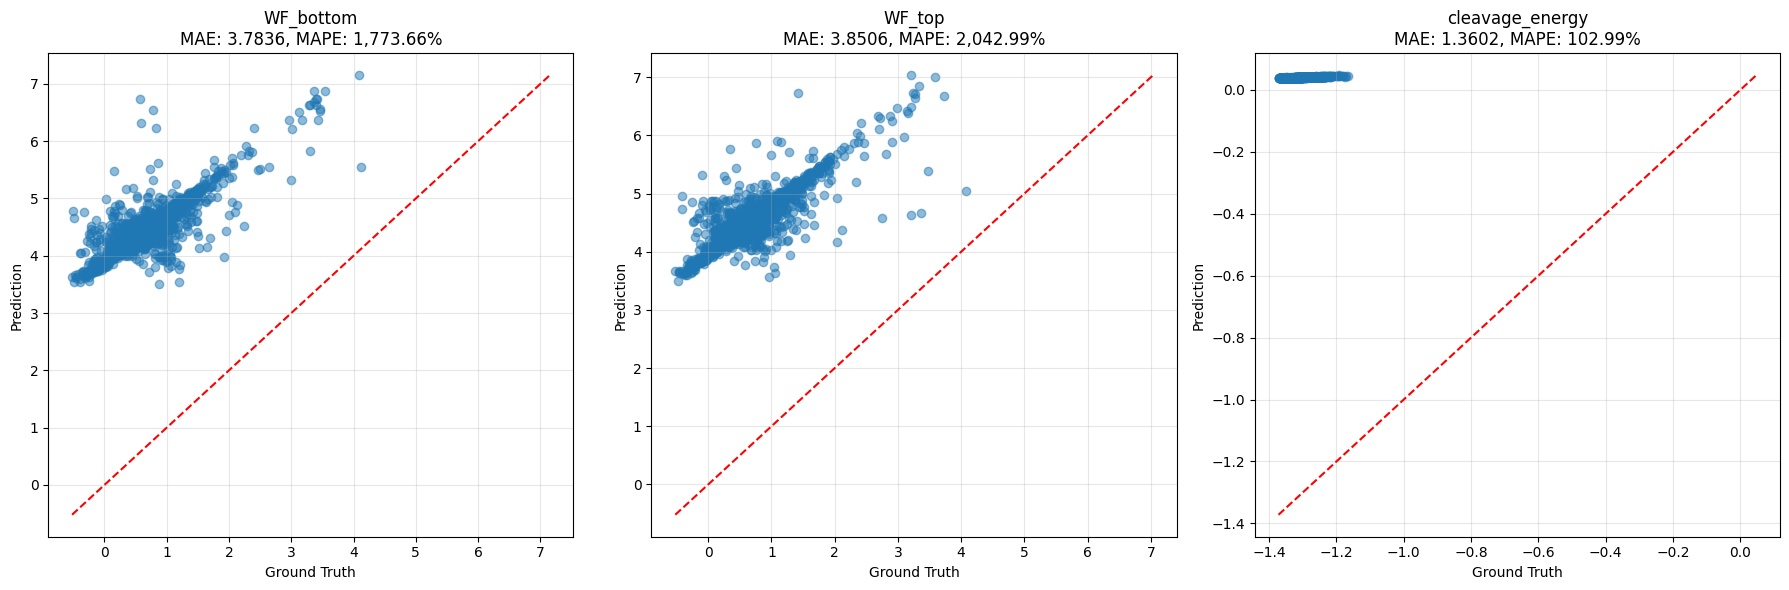

In [14]:
# Create scatter plots for each property
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(target_cols):
    pred_col = f"{col}_pred_destd"
    
    axs[i].scatter(merged_results[col], merged_results[pred_col], alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(merged_results[col].min(), merged_results[pred_col].min())
    max_val = max(merged_results[col].max(), merged_results[pred_col].max())
    axs[i].plot([min_val, max_val], [min_val, max_val], 'r--')
    
    axs[i].set_xlabel('Ground Truth')
    axs[i].set_ylabel('Prediction')
    axs[i].set_title(f'{col}\nMAE: {metrics_df.loc[i, "MAE"]:.4f}, MAPE: {metrics_df.loc[i, "MAPE (%)"]:,.2f}%')
    axs[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(repo_root, 'output/D2R2_multi3/prediction_vs_ground_truth.png'), dpi=300)
plt.show()

## 9. Error Distribution Analysis

Let's visualize the distribution of prediction errors for each property.

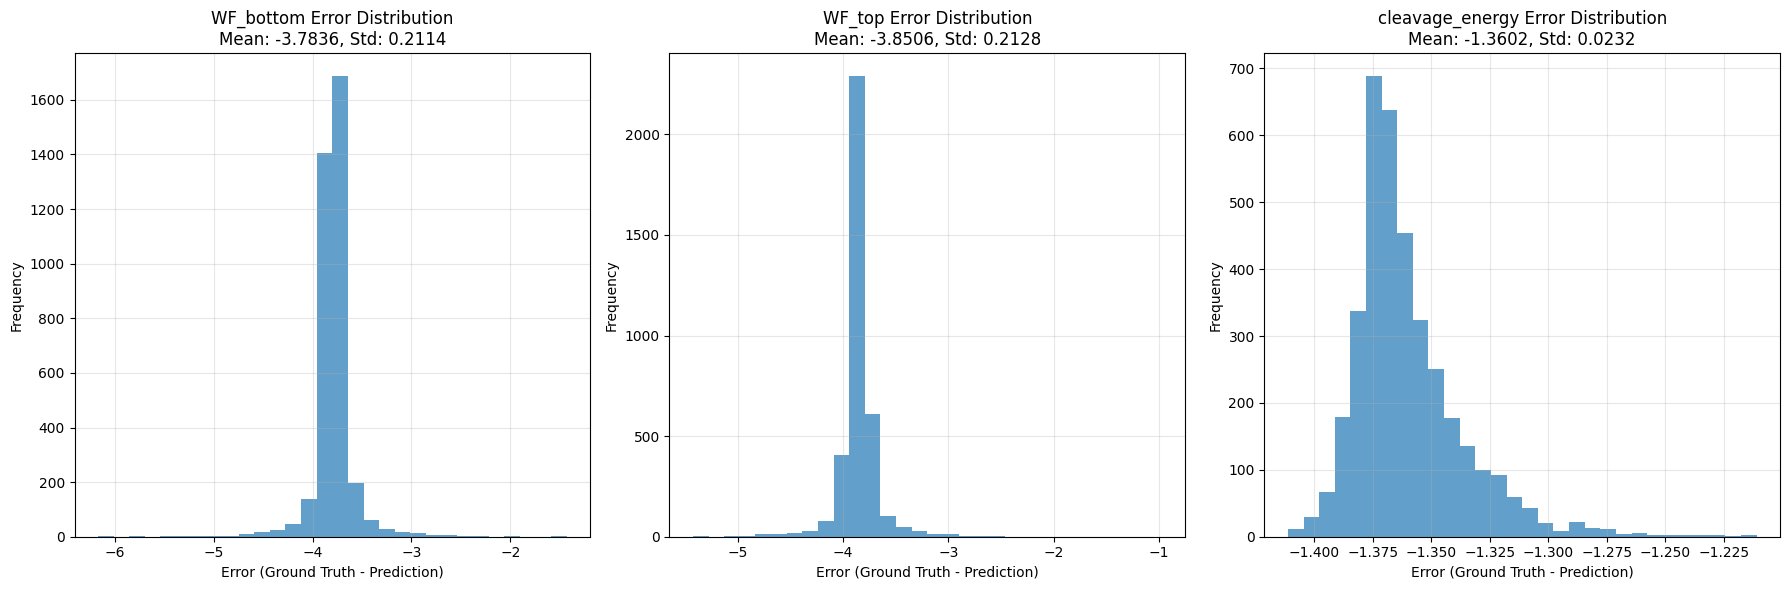

In [15]:
# Create error histograms for each property
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(target_cols):
    pred_col = f"{col}_pred_destd"
    
    # Calculate errors
    errors = merged_results[col] - merged_results[pred_col]
    
    # Plot histogram
    axs[i].hist(errors, bins=30, alpha=0.7)
    axs[i].set_xlabel('Error (Ground Truth - Prediction)')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'{col} Error Distribution\nMean: {errors.mean():.4f}, Std: {errors.std():.4f}')
    axs[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(repo_root, 'output/D2R2_multi3/error_distribution.png'), dpi=300)
plt.show()

## 10. Save Processed Results

Finally, let's save the processed results to a CSV file for future reference.

In [ ]:
# Save the merged results to a CSV file
output_file = os.path.join(repo_root, 'output/D2R2_multi3/analyzed_results.csv')
merged_results.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

# Save metrics to a CSV file
metrics_file = os.path.join(repo_root, 'output/D2R2_multi3/performance_metrics.csv')
metrics_df.to_csv(metrics_file, index=False)
print(f"Metrics saved to {metrics_file}")